<a href="https://colab.research.google.com/github/yasinsoylu1997/128_under/blob/main/vgg19_models_128_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost

     |████████████████████████████████| 992 kB 5.2 MB/s 
     |████████████████████████████████| 76.6 MB 91 kB/s 


In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:17<00:00, 78.82it/s] 


In [5]:
from imblearn.under_sampling import RandomUnderSampler 

reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomUnderSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,128,128,3)
oversampled_y

array(['COVID', 'COVID', 'COVID', ..., 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia'], dtype='<U15')

In [6]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

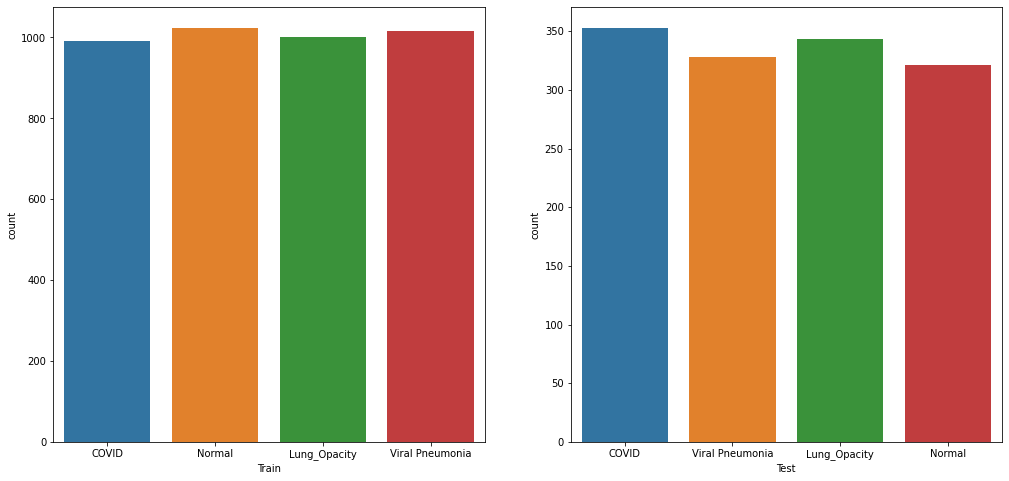

In [7]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [12]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [13]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

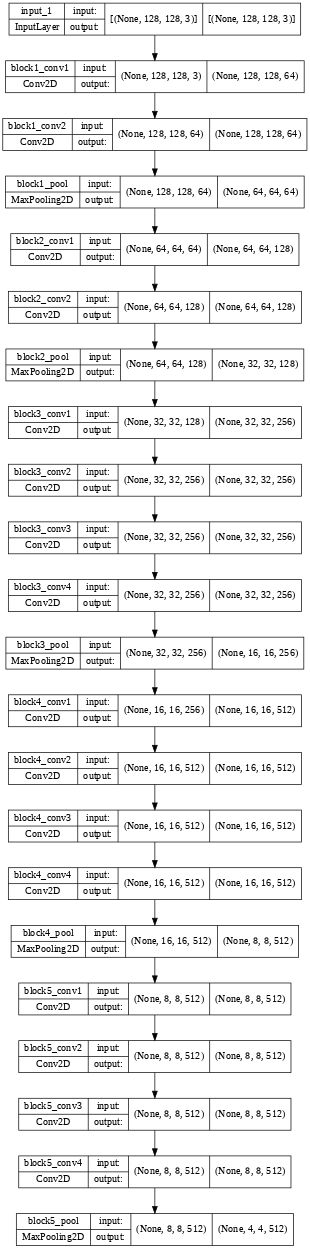

In [14]:
from keras.utils.vis_utils import plot_model

plot_model(VGG_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

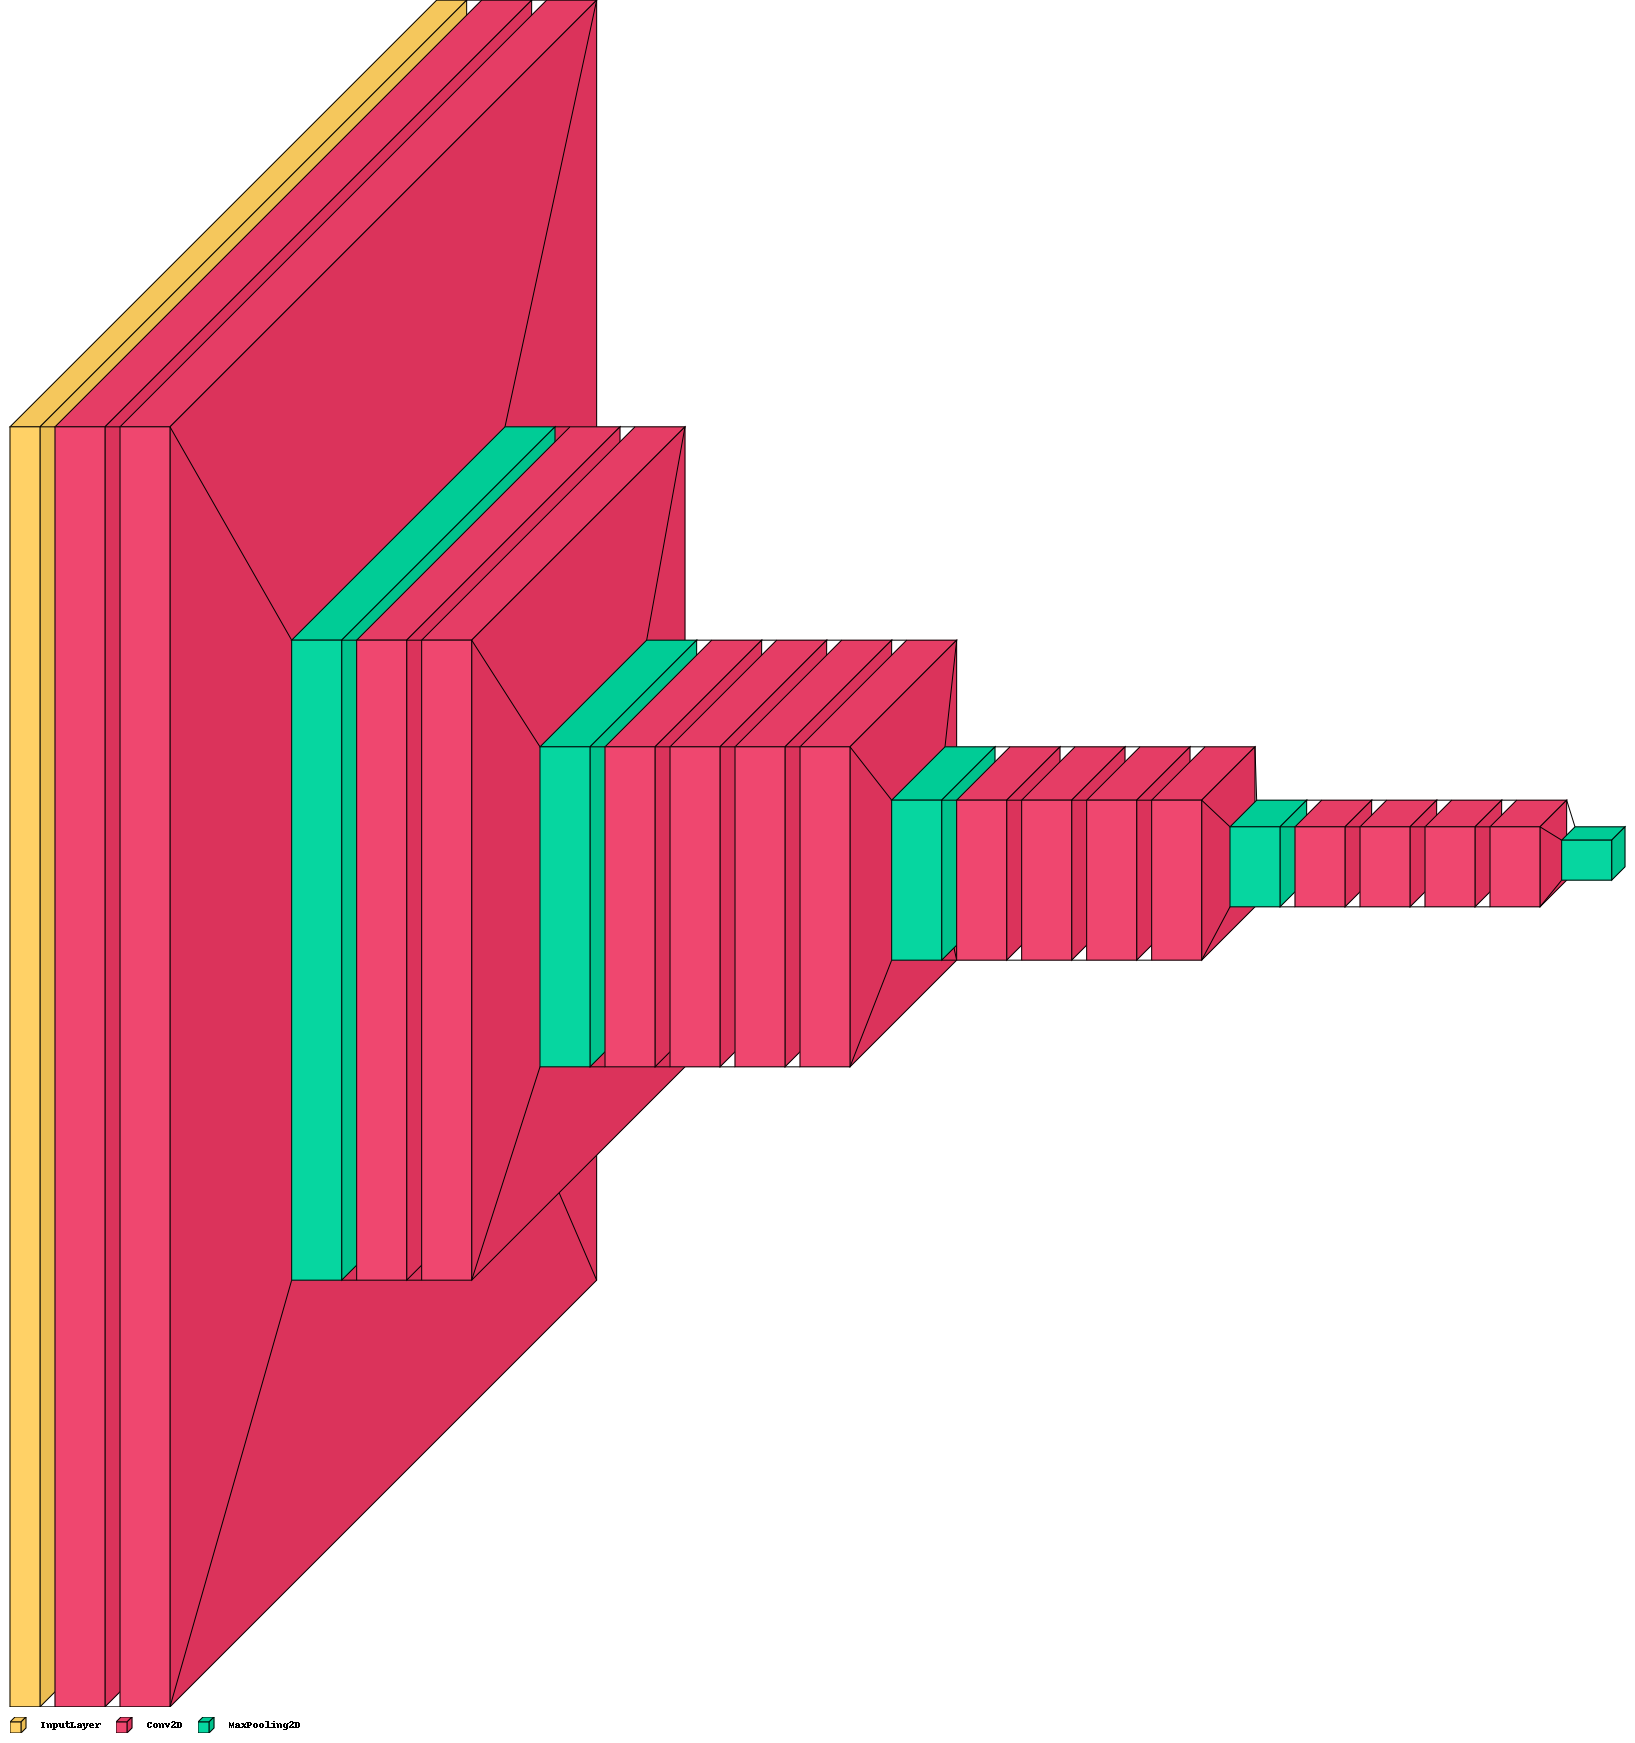

<Figure size 144x144 with 0 Axes>

In [15]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(VGG_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [16]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [18]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [19]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.38661710037174724
MSE: 0.6260223048327137
RMSE: 0.7912157132114565
R2 Square 0.5036843816751206
Accuracy 0.7256505576208179
__________________________________


In [20]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.386617,0.626022,0.791216,0.503684,0.725651


In [21]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60       353
           1       0.70      0.66      0.68       343
           2       0.67      0.75      0.70       321
           3       0.94      0.92      0.93       328

    accuracy                           0.73      1345
   macro avg       0.73      0.73      0.73      1345
weighted avg       0.73      0.73      0.73      1345



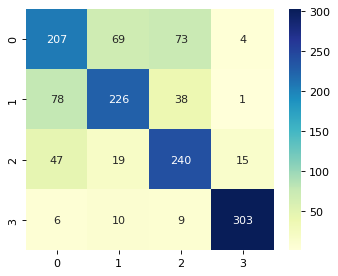

In [22]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [24]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [25]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5494423791821561
MSE: 0.9360594795539033
RMSE: 0.9675016690186655
R2 Square 0.25788436642396306
Accuracy 0.6223048327137547
__________________________________


In [26]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.386617,0.626022,0.791216,0.503684,0.725651
1,DecisionTreeClassifier,0.549442,0.936059,0.967502,0.257884,0.622305


In [27]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.52      0.53      0.53       353
           1       0.59      0.54      0.56       343
           2       0.55      0.58      0.56       321
           3       0.84      0.85      0.85       328

    accuracy                           0.62      1345
   macro avg       0.62      0.62      0.62      1345
weighted avg       0.62      0.62      0.62      1345



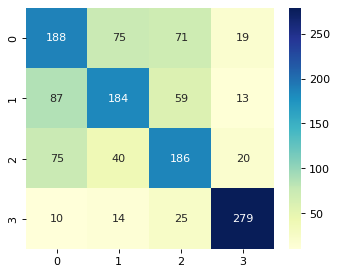

In [28]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [29]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [30]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [31]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.27732342007434946
MSE: 0.433457249070632
RMSE: 0.6583747026356891
R2 Square 0.6563515374306358
Accuracy 0.7977695167286245
__________________________________


In [32]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.386617,0.626022,0.791216,0.503684,0.725651
1,DecisionTreeClassifier,0.549442,0.936059,0.967502,0.257884,0.622305
2,LogisticRegression,0.277323,0.433457,0.658375,0.656352,0.797770


In [33]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       353
           1       0.78      0.73      0.75       343
           2       0.75      0.79      0.77       321
           3       0.98      0.95      0.96       328

    accuracy                           0.80      1345
   macro avg       0.80      0.80      0.80      1345
weighted avg       0.80      0.80      0.80      1345



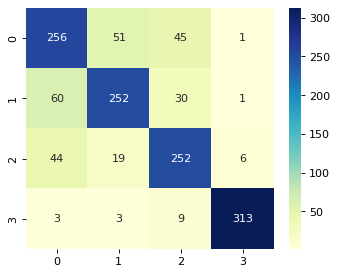

In [34]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [35]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [36]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [37]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.25427509293680295
MSE: 0.38810408921933087
RMSE: 0.6229800070783419
R2 Square 0.6923078945776876
Accuracy 0.8096654275092937
__________________________________


In [38]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.386617,0.626022,0.791216,0.503684,0.725651
1,DecisionTreeClassifier,0.549442,0.936059,0.967502,0.257884,0.622305
2,LogisticRegression,0.277323,0.433457,0.658375,0.656352,0.797770
3,LGBMClassifier,0.254275,0.388104,0.622980,0.692308,0.809665


In [39]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       353
           1       0.77      0.77      0.77       343
           2       0.77      0.80      0.78       321
           3       0.96      0.95      0.96       328

    accuracy                           0.81      1345
   macro avg       0.81      0.81      0.81      1345
weighted avg       0.81      0.81      0.81      1345



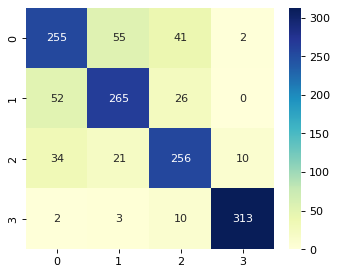

In [40]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [42]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [43]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3182156133828996
MSE: 0.5144981412639406
RMSE: 0.7172852579441045
R2 Square 0.5921016533481989
Accuracy 0.7724907063197026
__________________________________


In [44]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.386617,0.626022,0.791216,0.503684,0.725651
1,DecisionTreeClassifier,0.549442,0.936059,0.967502,0.257884,0.622305
2,LogisticRegression,0.277323,0.433457,0.658375,0.656352,0.797770
3,LGBMClassifier,0.254275,0.388104,0.622980,0.692308,0.809665
4,RandomForestClassifier,0.318216,0.514498,0.717285,0.592102,0.772491


In [45]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       353
           1       0.73      0.74      0.73       343
           2       0.76      0.75      0.76       321
           3       0.95      0.95      0.95       328

    accuracy                           0.77      1345
   macro avg       0.78      0.77      0.78      1345
weighted avg       0.77      0.77      0.77      1345



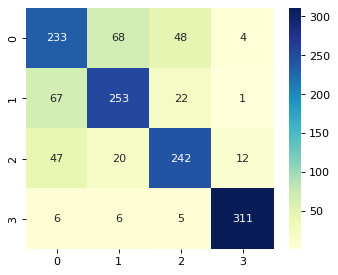

In [46]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [47]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [48]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [49]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5643122676579926
MSE: 0.9182156133828996
RMSE: 0.9582356773690383
R2 Square 0.27203112989165557
Accuracy 0.5970260223048327
__________________________________


In [50]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.386617,0.626022,0.791216,0.503684,0.725651
1,DecisionTreeClassifier,0.549442,0.936059,0.967502,0.257884,0.622305
2,LogisticRegression,0.277323,0.433457,0.658375,0.656352,0.797770
3,LGBMClassifier,0.254275,0.388104,0.622980,0.692308,0.809665
4,RandomForestClassifier,0.318216,0.514498,0.717285,0.592102,0.772491
5,GaussianNB,0.564312,0.918216,0.958236,0.272031,0.597026


In [51]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.57      0.25      0.35       353
           1       0.60      0.64      0.62       343
           2       0.47      0.82      0.60       321
           3       0.90      0.70      0.79       328

    accuracy                           0.60      1345
   macro avg       0.63      0.60      0.59      1345
weighted avg       0.63      0.60      0.58      1345



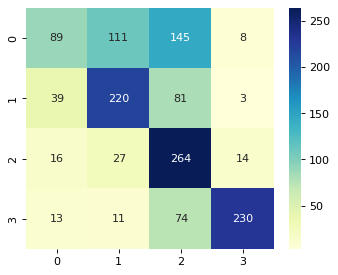

In [52]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [53]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [54]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [55]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.2654275092936803
MSE: 0.4275092936802974
RMSE: 0.6538419485474279
R2 Square 0.6610671252531999
Accuracy 0.8118959107806691
__________________________________


In [56]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.386617,0.626022,0.791216,0.503684,0.725651
1,DecisionTreeClassifier,0.549442,0.936059,0.967502,0.257884,0.622305
2,LogisticRegression,0.277323,0.433457,0.658375,0.656352,0.797770
3,LGBMClassifier,0.254275,0.388104,0.622980,0.692308,0.809665
4,RandomForestClassifier,0.318216,0.514498,0.717285,0.592102,0.772491
5,GaussianNB,0.564312,0.918216,0.958236,0.272031,0.597026
6,SGDClassifier,0.265428,0.427509,0.653842,0.661067,0.811896


In [57]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       353
           1       0.83      0.73      0.78       343
           2       0.80      0.74      0.77       321
           3       0.94      0.97      0.96       328

    accuracy                           0.81      1345
   macro avg       0.82      0.81      0.81      1345
weighted avg       0.82      0.81      0.81      1345



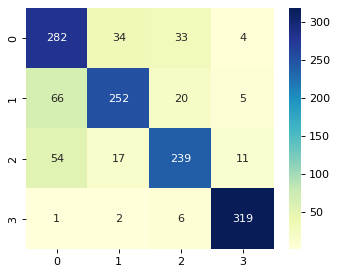

In [58]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [59]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [60]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [61]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.2728624535315985
MSE: 0.42156133828996284
RMSE: 0.649277551044207
R2 Square 0.6657827130757641
Accuracy 0.7992565055762082
__________________________________


In [62]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.386617,0.626022,0.791216,0.503684,0.725651
1,DecisionTreeClassifier,0.549442,0.936059,0.967502,0.257884,0.622305
2,LogisticRegression,0.277323,0.433457,0.658375,0.656352,0.797770
3,LGBMClassifier,0.254275,0.388104,0.622980,0.692308,0.809665
4,RandomForestClassifier,0.318216,0.514498,0.717285,0.592102,0.772491
5,GaussianNB,0.564312,0.918216,0.958236,0.272031,0.597026
6,SGDClassifier,0.265428,0.427509,0.653842,0.661067,0.811896
7,SVC,0.272862,0.421561,0.649278,0.665783,0.799257


In [63]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       353
           1       0.77      0.74      0.76       343
           2       0.76      0.78      0.77       321
           3       0.99      0.95      0.97       328

    accuracy                           0.80      1345
   macro avg       0.80      0.80      0.80      1345
weighted avg       0.80      0.80      0.80      1345



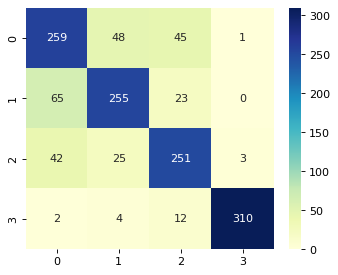

In [64]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [65]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]


In [66]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_vgg19"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_vgg19"])
    sonuclar = sonuclar.append(sonuc)
    

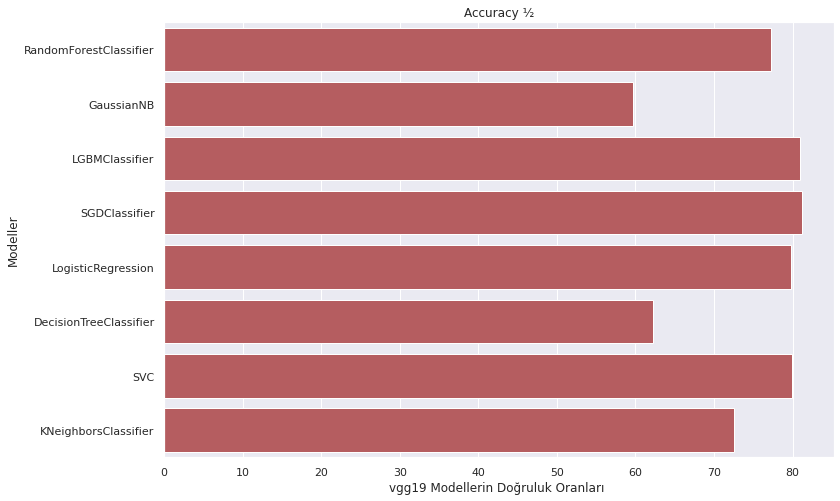

In [67]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x= 'Accuracy_vgg19', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('vgg19 Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [68]:
best_acc=sonuclar.sort_values(by=['Accuracy_vgg19'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model

,Modeller,Accuracy_vgg19
0,SGDClassifier,81.189591


In [69]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.386617,0.626022,0.791216,0.503684,0.725651
1,DecisionTreeClassifier,0.549442,0.936059,0.967502,0.257884,0.622305
2,LogisticRegression,0.277323,0.433457,0.658375,0.656352,0.797770
3,LGBMClassifier,0.254275,0.388104,0.622980,0.692308,0.809665
4,RandomForestClassifier,0.318216,0.514498,0.717285,0.592102,0.772491
5,GaussianNB,0.564312,0.918216,0.958236,0.272031,0.597026
6,SGDClassifier,0.265428,0.427509,0.653842,0.661067,0.811896
7,SVC,0.272862,0.421561,0.649278,0.665783,0.799257


In [70]:
from google.colab import files

results_df.to_csv('output_vgg19_224.csv', encoding = 'utf-8-sig') 
files.download('output_vgg19_224.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>